# 4.2 Word2Vec

먼저 책 내용을 따라한 후 파이토치로 구현해보자!

In [1]:
#corpus_fname = '../data/tokenized/korquad_mecab.txt'
corpus_fname = '../data/tokenized/corpus_mecab.txt'
model_fname = '../data/word_embeddings/word2vec/word2vec'

from gensim.models import Word2Vec

In [2]:
%%time
corpus = [sent.strip().split(" ") for sent in open(corpus_fname, 'r', encoding='utf-8').readlines()]
model = Word2Vec(corpus, size=100, workers=4, sg=1)
model.save(model_fname)

Wall time: 1h 14min 41s


책에서는 미리 만들어둔 클래스를 쓰는데 그게 khaiii를 필요로 하므로, 여기선 그냥 gensim 라이브러리 사용법이나 익혀보자.

In [6]:
# 두 단어 사이의 유사도
model.wv.similarity('한국','일본')

0.7600878

In [7]:
# 가장 유사한 단어 찾기
model.wv.most_similar('한국') # 옵션은 topn=10 이 디폴트

[('일본', 0.7600878477096558),
 ('미국', 0.7370491027832031),
 ('중국', 0.7336530685424805),
 ('대한민국', 0.6903994083404541),
 ('우리나라', 0.6695072650909424),
 ('국내', 0.6565845012664795),
 ('최고', 0.6536493301391602),
 ('북한', 0.6467779874801636),
 ('나라', 0.6412838697433472),
 ('산증인', 0.6291565895080566)]

In [8]:
%%time
model.wv.most_similar('컴퓨터') # 옵션은 topn=10 이 디폴트

Wall time: 30 ms


[('하드웨어', 0.819138765335083),
 ('주변기기', 0.7951250076293945),
 ('임베디드', 0.7927801609039307),
 ('PDA', 0.7920290231704712),
 ('노트북', 0.7857601642608643),
 ('컴퓨팅', 0.7803535461425781),
 ('데스크톱', 0.776055634021759),
 ('마이크로컴퓨터', 0.7725406885147095),
 ('응용', 0.7718737125396729),
 ('랩톱', 0.7710766792297363)]

In [10]:
# word analogy는 다음과 같이 사용 가능
model.wv.most_similar(positive=['왕','여자'],negative=['남자'],topn=3)

[('왕국', 0.7107855081558228),
 ('여왕', 0.7011860609054565),
 ('군주', 0.6778603792190552)]

In [11]:
model.wv.most_similar(positive=['서울','프랑스'],negative=['한국'],topn=3)

[('파리', 0.694817066192627),
 ('툴루즈', 0.6836140155792236),
 ('낭시', 0.6809982657432556)]

In [12]:
model.wv.most_similar(positive=['홈런','축구'],negative=['야구'],topn=3)

[('득점', 0.6441534161567688),
 ('타점', 0.6425706744194031),
 ('호골', 0.6362104415893555)]

In [16]:
# 벡터 표현은 어떻게 ?
model.wv['한국'].shape

(100,)

In [20]:
# 단어 갯수
len(model.wv.vocab)

358043

In [24]:
# index 와 단어
model.wv.index2word[1000]

'인터넷'

In [28]:
word_to_id = dict([])

for i in range(len(model.wv.vocab)):
    word = model.wv.index2word[i]
    word_to_id[word] = i

In [29]:
word_to_id['인터넷']

1000

이런 식으로 워드벡터를 얻을 수 있다!

In [0]:
import os, sys
sys.path.append('F:\Google 드라이브\Programming\한국어 임베딩')

In [0]:
from models.word_eval import WordEmbeddingEvaluator
model = WordEmbeddingEvaluator('../data/word_embeddings/word2vec/word2vec',\
                              dim=100, tokenizer_name='mecab')

ModuleNotFoundError: No module named 'khaiii'

ValueError: attempted relative import beyond top-level package

에라이 망...

구현이나 해보자.
먼저 텍스트 데이터 생성부터 하자.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda')

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
   
# PyDrive Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [6]:
!ls "/gdrive/My Drive/Programming/한국어 임베딩"

Chap3  Chap4  data  images  models  preprocess	README.md


In [0]:
N = 3 # 윈도우 갯수
VEC_DIM = 100 # 임베딩 차원

In [0]:
#txt_path = '../data/tokenized/korquad_mecab.txt'
txt_path = '/gdrive/My Drive/Programming/한국어 임베딩/data/tokenized/korquad_mecab.txt'
corpus = [sent.strip().split() for sent in open(txt_path, 'r', encoding='utf-8').readlines()]

In [0]:
#txt_path2 = '../data/tokenized/ratings_mecab.txt'
txt_path2 = '/gdrive/My Drive/Programming/한국어 임베딩/data/tokenized/ratings_mecab.txt'
corpus2 = [sent.strip().split() for sent in open(txt_path2, 'r', encoding='utf-8').readlines()]

In [15]:
corpus2[100]

['대박', '이', '였', '지', '이건', '한마디', '로', '.', '.']

In [0]:
corpus_data = corpus# + corpus2

In [0]:
corpus_data[0]

In [18]:
vocab = set()
for i in range(len(corpus_data)):
    vocab.update(corpus_data[i])
    
print('단어 갯수 : ' + str(len(vocab)))

word_to_id = dict()
for word in vocab:
    word_to_id[word]=len(word_to_id)    
    
id_to_word = []
for word in word_to_id.keys():
    id_to_word.append(word)

단어 갯수 : 83593


In [0]:
corpus[1]

In [0]:
def sent_to_ngram(n, sent):
    ngrams = []
    
    for i in range(n, len(sent)-n):
        ngram = []
        for j in range(-n,n+1):
            ngram.append(sent[i+j])
        ngrams.append(ngram)
            
    return ngrams

In [20]:
sent_to_ngram(3,corpus[1])

[['바그너', '는', '괴테', '의', '파우스트', '를', '읽'],
 ['는', '괴테', '의', '파우스트', '를', '읽', '고'],
 ['괴테', '의', '파우스트', '를', '읽', '고', '무엇'],
 ['의', '파우스트', '를', '읽', '고', '무엇', '을'],
 ['파우스트', '를', '읽', '고', '무엇', '을', '쓰'],
 ['를', '읽', '고', '무엇', '을', '쓰', '고자'],
 ['읽', '고', '무엇', '을', '쓰', '고자', '했'],
 ['고', '무엇', '을', '쓰', '고자', '했', '는가'],
 ['무엇', '을', '쓰', '고자', '했', '는가', '?'],
 ['을', '쓰', '고자', '했', '는가', '?', '교향곡']]

In [0]:
train_data = []
for i in range(len(corpus_data)):
    train_data += sent_to_ngram(N, corpus_data[i])

In [0]:
def sent_to_vec(sent):
    vec = []
    for word in sent:
        vec.append(word_to_id[word])
    return vec

In [23]:
sent_to_ngram(3,corpus_data[1])[0]

['바그너', '는', '괴테', '의', '파우스트', '를', '읽']

In [0]:
sent_to_vec(train_data[0]),sent_to_vec(train_data[1])

([26494, 31901, 26200, 81583, 14801, 45264, 59443],
 [31901, 26200, 81583, 14801, 45264, 59443, 70316])

In [0]:
train_input = []
train_target = []
for data in train_data:
    train_input.append(sent_to_vec(data[:N])+sent_to_vec(data[N+1:]))
    train_target.append(word_to_id[data[N]])

In [0]:
train = torch.utils.data.TensorDataset(torch.tensor(train_input), torch.tensor(train_target))

CBOW 모델 생성

In [0]:
class CBOW(nn.Module):
    def __init__(self, vec_dim):
        super(CBOW,self).__init__()
        self.emb = nn.Embedding(len(vocab), vec_dim)
        self.lin = nn.Linear(vec_dim, len(vocab), bias=False)
        
    def forward(self, x):
        x = torch.mean(self.emb(x), dim=1)
        x = self.lin(x).view(-1,len(vocab))
        return x

In [0]:
model = CBOW(VEC_DIM)

In [0]:
loss_f = nn.CrossEntropyLoss()

In [0]:
model.to(dev)

CBOW(
  (emb): Embedding(83593, 100)
  (lin): Linear(in_features=100, out_features=83593, bias=False)
)

In [0]:
BATCH_SIZE = 128
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [0]:
input_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)

In [0]:
check = 1000
epoch = 1

In [0]:
# GPU time
start = time.time()

loss_list = []

for epo in range(epoch):
    loss_sum = 0
    for i, (x, y) in enumerate(input_loader):

        x,y = x.to(dev), y.to(dev)
        optimizer.zero_grad()
        
        output = model(x)
        
        loss = loss_f(output, y)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        
        
        if i % check == 0:        
            elap = int(time.time() - start)
            loss_list.append(loss_sum/check)
            print('Epoch : {}, Iteration : {}, Loss : {:.2f}, Elapsed time : {:.0f}h {:.0f}m {}s'.format(\
                epo, i, loss_sum / check, elap // 3600, (elap % 3600) // 60, str(int((elap % 3600) % 60))))
            loss_sum = 0

Epoch : 0, Iteration : 0, Loss : 0.01, Elapsed time : 0h 0m 0s
Epoch : 0, Iteration : 1000, Loss : 6.90, Elapsed time : 0h 0m 18s
Epoch : 0, Iteration : 2000, Loss : 6.76, Elapsed time : 0h 0m 37s
Epoch : 0, Iteration : 3000, Loss : 6.66, Elapsed time : 0h 0m 56s
Epoch : 0, Iteration : 4000, Loss : 6.46, Elapsed time : 0h 1m 15s
Epoch : 0, Iteration : 5000, Loss : 6.39, Elapsed time : 0h 1m 34s
Epoch : 0, Iteration : 6000, Loss : 6.29, Elapsed time : 0h 1m 53s
Epoch : 0, Iteration : 7000, Loss : 6.30, Elapsed time : 0h 2m 12s
Epoch : 0, Iteration : 8000, Loss : 6.31, Elapsed time : 0h 2m 31s
Epoch : 0, Iteration : 9000, Loss : 6.32, Elapsed time : 0h 2m 50s
Epoch : 0, Iteration : 10000, Loss : 6.05, Elapsed time : 0h 3m 8s
Epoch : 0, Iteration : 11000, Loss : 5.86, Elapsed time : 0h 3m 27s
Epoch : 0, Iteration : 12000, Loss : 6.04, Elapsed time : 0h 3m 46s
Epoch : 0, Iteration : 13000, Loss : 6.02, Elapsed time : 0h 4m 4s
Epoch : 0, Iteration : 14000, Loss : 5.98, Elapsed time : 0h 4m 

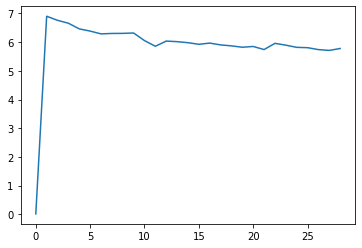

In [0]:
plt.plot(loss_list)

In [0]:
save_path = 'CBOW_N3_1epoch.pt'#.format(epoch)
torch.save(model.state_dict(), save_path)

In [0]:
path = 'CBOW_5epoch.pt'
model = CBOW(VEC_DIM)
model.load_state_dict(torch.load(path))
model.eval()

CBOW(
  (emb): Embedding(114937, 100)
  (lin): Linear(in_features=100, out_features=114937, bias=False)
)

In [0]:
def similar_words(model, word, k=10):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    word_id = torch.tensor([word_to_id[word]])
    word_vec = model.emb(word_id)
    word_mat = next(iter(model.emb.parameters())).detach()
    
    cos_mat = cos(word_vec, word_mat)
    sim, indices = torch.topk(cos_mat,k+1)
    
    
    word_list = []
    for i in indices:
        if i != word_id:
            word_list.append(id_to_word[i])
    return word_list, sim[1:].detach()

In [0]:
similar_words(model.to('cpu'), '지역')

(['곳', '시장', '민족', '구간', '빌리치', '영역', '지방', '나라', '간담', '붕당'],
 tensor([0.6377, 0.5033, 0.4792, 0.4789, 0.4776, 0.4514, 0.4473, 0.4390, 0.4388,
         0.4383]))

In [0]:
similar_words(model.to('cpu'), '어머니')

(['아버지', '아내', '그녀', '크기', '진정서', '인제', '피해자', '엄마', '정부', '세조'],
 tensor([0.5977, 0.5660, 0.5630, 0.5254, 0.5107, 0.4938, 0.4917, 0.4824, 0.4766,
         0.4732]))

In [0]:
similar_words(model.to('cpu'), '대한민국')

(['일본', '한국', '미국', '우라야스', '자국', '중국', '에스토니아', '왜관', 'Στίλβων', '대부분'],
 tensor([0.5484, 0.4867, 0.4831, 0.4346, 0.4197, 0.4153, 0.4115, 0.4053, 0.4029,
         0.4027]))

In [0]:
similar_words(model.to('cpu'), '컴퓨터')

(['정보', '캐릭터', '성능', '예물', '상식', '가치', '인터페이스', '변화', '으신다', '병리'],
 tensor([0.4606, 0.4514, 0.4488, 0.4450, 0.4408, 0.4169, 0.4166, 0.4081, 0.4036,
         0.4032]))

In [0]:
similar_words(model.to('cpu'), '')

In [0]:
def analogy(model, word1, word2, word3,k=10):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    word_id1 = torch.tensor([word_to_id[word1]])
    word_id2 = torch.tensor([word_to_id[word2]])
    word_id3 = torch.tensor([word_to_id[word3]])
    word_vec1 = model.emb(word_id1)
    word_vec2 = model.emb(word_id2)
    word_vec3 = model.emb(word_id3)
    word_mat = next(iter(model.emb.parameters())).detach()
    
    cos_mat = cos(word_vec1-word_vec2+word_vec3, word_mat)
    sim, indices = torch.topk(cos_mat,k)
    
    
    word_list = []
    for i in indices:
        word_list.append(id_to_word[i])
    return word_list, sim[1:].detach()

In [0]:
analogy(model,'한국','서울','파리')

(['파리', '한국', '참전', '산량', '입대', '사염', '걸쳐서', '프랑스와', '달했으며', '발매되'],
 tensor([0.5320, 0.5006, 0.3921, 0.3908, 0.3891, 0.3889, 0.3769, 0.3733, 0.3731]))

In [0]:
analogy(model,'왕','남자','여자')

(['왕', '동반성', '합당', '신탁', '핀란드어', '왕위', '여자', '와이드', '크시슈토프', '콜먼'],
 tensor([0.4096, 0.4065, 0.4057, 0.3908, 0.3795, 0.3704, 0.3678, 0.3669, 0.3643]))

N=5 일때보다 N=3 으로 하니까 뭔가 잘되는 느낌...
이제 skip-gram으로 해보자.

### 이번엔 Skip-gram 모델...

먼저 훈련데이터 형식을 [중심단어, 문맥단어] 으로 바꾸자.

In [24]:
%%time
train_input = []
train_target = []
for data in train_data:
    target = sent_to_vec(data[:N])+sent_to_vec(data[N+1:])
    for i in range(len(target)):
        train_input.append(word_to_id[data[N]])
        train_target.append(target[i])


CPU times: user 14.2 s, sys: 259 ms, total: 14.4 s
Wall time: 14.5 s


In [26]:
train_data[0], train_data[1]

(['1', '8', '3', '9', '년', '바그너', '는'], ['8', '3', '9', '년', '바그너', '는', '괴테'])

In [27]:
sent_to_vec(train_data[0])

[29472, 15343, 34852, 42498, 51549, 73060, 47173]

In [28]:
train_input[0], train_target[0]

(42498, 29472)

In [29]:
len(train_input), len(train_target)

(21793818, 21793818)

In [0]:
train = torch.utils.data.TensorDataset(torch.tensor(train_input), torch.tensor(train_target))

In [0]:
emb = nn.Embedding(len(vocab), VEC_DIM)
lin = nn.Linear(VEC_DIM, len(vocab), bias=False)

In [0]:
BATCH_SIZE=128
input_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
class Skipgram(nn.Module):
    def __init__(self, vec_dim):
        super(Skipgram,self).__init__()
        self.emb = nn.Embedding(len(vocab), vec_dim)
        self.lin = nn.Linear(vec_dim, len(vocab), bias=False)
        
    def forward(self, x):
        x = self.emb(x)
        x = self.lin(x)#.view(-1,len(vocab))
        return x

In [0]:
model_sg = Skipgram(VEC_DIM).to(dev)

In [0]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model_sg.parameters(), lr=0.01)

In [0]:
check = 5000
epoch = 3

In [37]:
model_sg.to(dev)

Skipgram(
  (emb): Embedding(83593, 100)
  (lin): Linear(in_features=100, out_features=83593, bias=False)
)

In [39]:
# GPU time
start = time.time()

loss_list = []

for epo in range(epoch):
    loss_sum = 0
    for i, (x, y) in enumerate(input_loader):

        x,y = x.to(dev), y.to(dev)
        optimizer.zero_grad()
        
        output = model_sg(x)
        
        loss = loss_f(output, y)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        
        
        if i % check == 0 && i != 0:        
            elap = int(time.time() - start)
            loss_list.append(loss_sum/check)
            print('Epoch : {}, Iteration : {}, Loss : {:.2f}, Elapsed time : {:.0f}h {:.0f}m {}s'.format(\
                epo+1, i, loss_sum / check, elap // 3600, (elap % 3600) // 60, str(int((elap % 3600) % 60))))
            loss_sum = 0

Epoch : 0, Iteration : 0, Loss : 0.00, Elapsed time : 0h 0m 2s
Epoch : 0, Iteration : 5000, Loss : 8.50, Elapsed time : 0h 1m 35s
Epoch : 0, Iteration : 10000, Loss : 7.86, Elapsed time : 0h 3m 7s
Epoch : 0, Iteration : 15000, Loss : 7.64, Elapsed time : 0h 4m 40s
Epoch : 0, Iteration : 20000, Loss : 7.52, Elapsed time : 0h 6m 13s
Epoch : 0, Iteration : 25000, Loss : 7.45, Elapsed time : 0h 7m 47s
Epoch : 0, Iteration : 30000, Loss : 7.38, Elapsed time : 0h 9m 20s
Epoch : 0, Iteration : 35000, Loss : 7.33, Elapsed time : 0h 10m 53s
Epoch : 0, Iteration : 40000, Loss : 7.29, Elapsed time : 0h 12m 26s
Epoch : 0, Iteration : 45000, Loss : 7.26, Elapsed time : 0h 13m 59s
Epoch : 0, Iteration : 50000, Loss : 7.22, Elapsed time : 0h 15m 32s
Epoch : 0, Iteration : 55000, Loss : 7.21, Elapsed time : 0h 17m 5s
Epoch : 0, Iteration : 60000, Loss : 7.19, Elapsed time : 0h 18m 39s
Epoch : 0, Iteration : 65000, Loss : 7.17, Elapsed time : 0h 20m 12s
Epoch : 0, Iteration : 70000, Loss : 7.15, Elapse

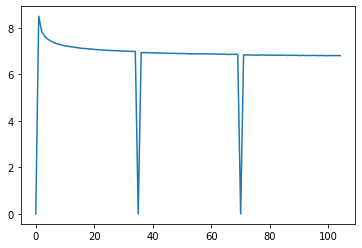

In [40]:
plt.plot(loss_list)

In [0]:
save_path = 'SG_N3_3epoch.pt'#.format(epoch)
torch.save(model_sg.state_dict(), save_path)

In [45]:
similar_words(model_sg.to('cpu'), '지역')

(['우주국', '書局', '創出', '장례식장', '래이', '영재', '쿨타임', 'Ysengrimus', '스카디', '미세눔'],
 tensor([0.4386, 0.4089, 0.4015, 0.3868, 0.3860, 0.3851, 0.3845, 0.3842, 0.3791,
         0.3789]))

In [46]:
similar_words(model_sg.to('cpu'), '어머니')

(['하인하르트', '단방', '코리', '장물아비', '옐친', '은금', '우터', '가상적국', '이려', 'CJ'],
 tensor([0.3991, 0.3911, 0.3765, 0.3765, 0.3760, 0.3723, 0.3722, 0.3718, 0.3674,
         0.3632]))

In [47]:
similar_words(model_sg.to('cpu'), '대한민국')

(['여전히', '과르디올라', '曹', '클레어', '무르시아', '르레', '가쓰라', '몰', '암살', '대납'],
 tensor([0.4307, 0.4155, 0.3974, 0.3910, 0.3882, 0.3862, 0.3861, 0.3860, 0.3850,
         0.3839]))

In [48]:
similar_words(model_sg.to('cpu'), '컴퓨터')

(['농경', '작곡', '무네타카', '덧붙여서', '에버', '미래', '도날드', '도합', '盟', '열어젖혔'],
 tensor([0.4262, 0.4255, 0.4025, 0.3987, 0.3985, 0.3980, 0.3969, 0.3926, 0.3808,
         0.3790]))

In [49]:
analogy(model_sg,'한국','서울','파리')

(['파리', '한국', '이누도', '疫', 'Staré', '『', 'League', '측우기', '로번', '관복'],
 tensor([0.5916, 0.3849, 0.3783, 0.3755, 0.3751, 0.3736, 0.3722, 0.3714, 0.3713]))